# Transfer learning

A hatékonyság növeléséhez célszerű lehet a tanítóminták számát drasztikusan növelni -- ha ez nem lehetséges, akkor más megoldásokhoz célszerű folyamodni. Például kipróbálhatunk több a feladatnak dedikált architektúrát, majd a hiperparaméterek optimális megválasztásával mozdulhatunk jobb és jobb megoldások felé.

Egy további irány, ha felhasználunk korábbi eredményeket: kutyák és macskák megkülönböztetésével foglalkozunk, akkor esetleg felhasználhatunk olyan képi klasszifikációhoz kapcsolódó eredményeket, amelyek nem kifejezetten kutyákhoz és macskákhoz kapcsolódnak.

Innen ered a *transfer learning* ötlete: vegyünk egy betanított neurális hálózatot, amely valamely nagy, általános probléma megoldására képes. A tanításához a nekünk rendelkezésre álló adatoknál nagyságrendileg több minta állt rendelkezésre.

Elemezzük, hogy *"mit lát"* a konvolúciós hálózat: mire aktiválnak a felső rétegek, és mire aktiválnak a mélyebb rétegek? Azt figyelhetjük meg, hogy a felső rétegek általános, alacsony szintű képi jellemzőket keresnek: éleket, csúcsokat. Mélyebb réteget ezekből az egyszerűbb formákból felépített összetett jellemzőkre aktiválnak. Az ideális macskadetektor *macskákra* aktivál, de ennek egyszerűbb elemei a macska fülei vagy a szemei: ideális esetben ilyen, az egyes kategóriákra jellemző *feature*ket keresnek a konvolúciós filterek.

Legyen az a feltételezésünk, hogy az egyszerű jellemzőket nem szükséges kutyákra és macskákra specializálni, általában digitális fényképek esetén vett jellemzők megfelelőek lehetnek. Amennyiben a megoldást kutyákra és macskákra akarjuk kihegyezni, akkor a mélyebb rétegek esetén szükséges csak tanítanunk. Tehát elindulhatnánk egy olyan irányba, ahol egy klasszikus hálózatot veszük, betöltjük például az ImageNet ILSVRC 1000 kategoriájához tartozó súlyparamétereket, és csak a *mély* rétegek tanításával foglalkozunk!

In [1]:
from keras.preprocessing.image import ImageDataGenerator

imsize = 224

train_gen = ImageDataGenerator(rescale=1./255, 
                               featurewise_std_normalization=True)

train_data = train_gen.flow_from_directory("catsvsdogs\\training_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                          )

test_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

test_data = test_gen.flow_from_directory("catsvsdogs\\test_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                         )

c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


Ha rendelkezésre áll GPU, akkor javasolt a VGG-16 átalakítása. A lentebbi példa a MobileNetV2-re épül.

Meghatározzuk a modell súlyait: ezt egy **wget** kéréssel le is tölti számunkra, amely kis ideig tarthat. A *classes* értéke ez esetben csak 1000 lehet, hisz a súlyparaméterek csak ilyen modellbe tölthetőek be.

In [2]:
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(include_top=True, weights='imagenet', classes=1000)

14536120/14536120 [==============================] - 1s 0us/step


In [3]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

A modell kész és használató, ha az adatok az ImageNet 1000 kategoriájából vannak. Ez persze nem így van, így átalakításokra lesz szükség.

In [4]:
model.layers[113].name

'block_12_project'

Válasszuk ki, hogy meddig kívánjuk a betanított paramétereket akalmazni, és hol legyen az a pont, ahonnan tanítjuk a hálózatot: én a 12. blokkig szeretném az imagenet paramétereket megtartani.

In [5]:
for l in model.layers[:113]:
    l.trainable = False

Hamisra állítva a *trainable* propertyt a model adott *layer*einek súlyparaméterei nem módosulnak tanítás során.

In [6]:
print(model.layers[112].trainable)
print(model.layers[113].trainable)

False
True


Az architektúra utolsó rétegeivel még gond van: 1000 neuronból álló softmax aktivált Dense réteg helyett egyetlen szigmoid aktivált neuron kell.

Ennek megoldásához az utolsó előtti réteg mögé új réteget kötünk be, a keras úgynevezett *functional API*-ját alkalmazva: a *X = Dense(...)(Y.output)* azt jelöli, hogy a létrehozott *X* layer bemenete, az *Y*-ként jelölt layer kimenete lesz.

In [7]:
from keras.layers import Dense
from keras.models import Model

utolsoelotti = model.layers[-2]
ujutolso = Dense(1, activation='sigmoid')(utolsoelotti.output)

ujmodel = Model(inputs=model.input, outputs=ujutolso)

In [8]:
ujmodel.summary()
model = ujmodel

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Megtekintva az új architektúrát két dolgot kell megfigyelni: egyrészt persze az utolsó réteg az imént létrehozott 1 elemű Dense réteg sigmoid aktivációval. Másrészt a modell paraméterszáma és tanítható paramétereinek száma nem egyezik, nagyjából félmillió paramétert fixként kezelünk.

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
from keras.callbacks import TensorBoard

tbcb = TensorBoard(log_dir="./logs/MobileNetV2-transferlearning")

In [11]:
model.fit_generator(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=[tbcb]
                   )

C:\Users\dezsics\AppData\Local\Temp\ipykernel_27792\1109840961.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} . is not a directory [Op:CreateSummaryFileWriter]

Tanítást követően a tanulság tankönyvi példába illik: a *tudástranszfer* működik, a modell gyorsan konvergál a tökéletes precízió irányába. Ugyanakkor persze van egy küszöb, amelyet ez sem fog átlépni.

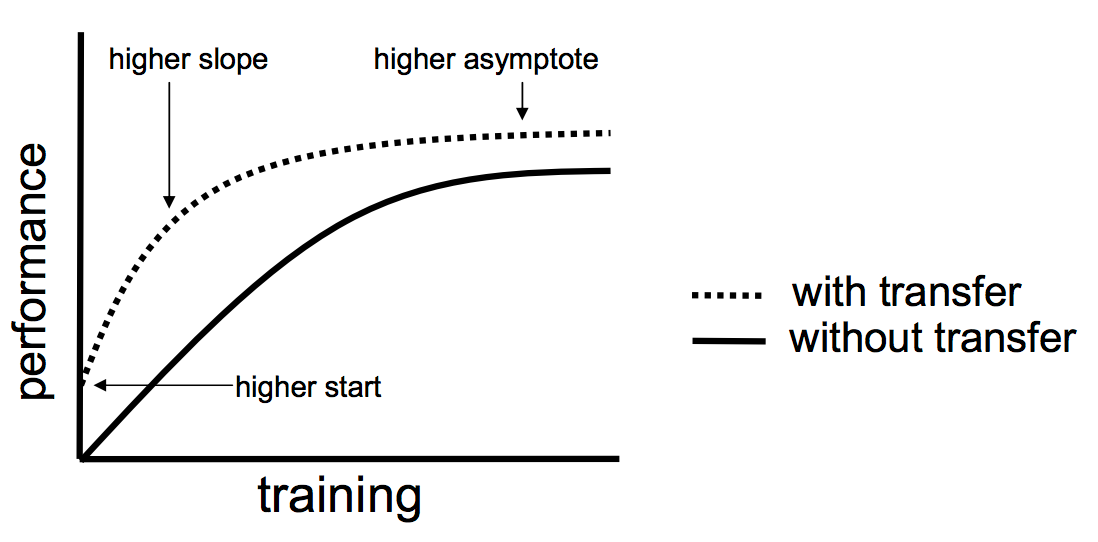

- ha lehet, ne találjunk fel új neurális architektúrát;
- amennyiben van rá lehetőség, alkalmazzunk transfer learninget;
- transfer learning esetén magasabb klasszifikációs pontosság érhető el, ha kevés a rendelkezésre álló tanítóminta;
- transfer learning esetén gyorsabb a konvergencia;
- ügyeljünk rá, hogy az eredeti tanítóadatok eloszlása nem feltétlenül azonos a későbbi tanítóhalmaz eloszlásával, amely torzulást okozhat a következtetésben (ezt nevezik *selection bias*-nak).